#  XPCS   Pipeline 

Get the data from databroker

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler

 ### Easily switch between interactive and static matplotlib plots

In [10]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

### Lazy Eiger Handler (later will goto databroker)

In [12]:
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

class FixedEigerImages(EigerImages):
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs

    def __init__(self, fpath, frame_per_point):
        # create pims handler
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        # TODO Return a multi-dimensional PIMS seq.
        return FixedEigerImages(master_path)

register_handler('AD_EIGER', LazyEigerHandler)  # Register it so filestore knows to use it.

RuntimeError: You are trying to register a second handler for spec AD_EIGER, {'npy': <class 'filestore.handlers.NpyHandler'>, 'AD_HDF5': <class 'filestore.handlers.AreaDetectorHDF5Handler'>, 'AD_SPE': <class 'filestore.handlers.AreaDetectorSPEHandler'>, 'AD_TIFF': <class 'filestore.handlers.AreaDetectorTiffHandler'>, 'MAPS_PLANE': <class 'filestore.handlers.HDFMapsEnergyHandler'>, 'npy_FRAMEWISE': <class 'filestore.handlers.NpyFrameWise'>, 'MAPS_SPECTRUM': <class 'filestore.handlers.HDFMapsSpectrumHandler'>, 'AD_EIGER': <class '__main__.LazyEigerHandler'>}

### Get the events from the uid

In [13]:
events = get_events(db['e59f567d'], ['eiger_4M_cam_img_image_lightfield'])
ev = next(events)

In [14]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
imgs

<Frames>
Length: 3000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

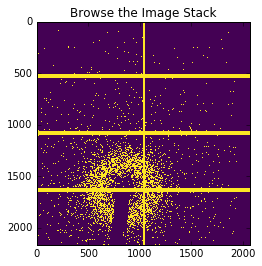

<function __main__.view_image>

In [15]:
from ipywidgets import interact

def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 2999))

### Get the Averaged Image Data

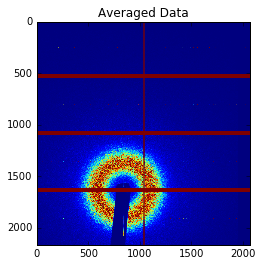

In [16]:
avg_img = np.average(imgs, axis=0)

# Plot the result
fig, ax = plt.subplots()
ax.imshow(avg_img, vmin=0, vmax=1e0)
ax.set_title("Averaged Data")
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [17]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as utils

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Note:  Enter the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [18]:
# The physical size of the pixels
dpix = 0.075  
 
lambda_ = 1.3776    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance

exposuretime= 100e-3
acquisition_period = 100e-3

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Create the mask file

More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

<IPython.core.display.Javascript object>


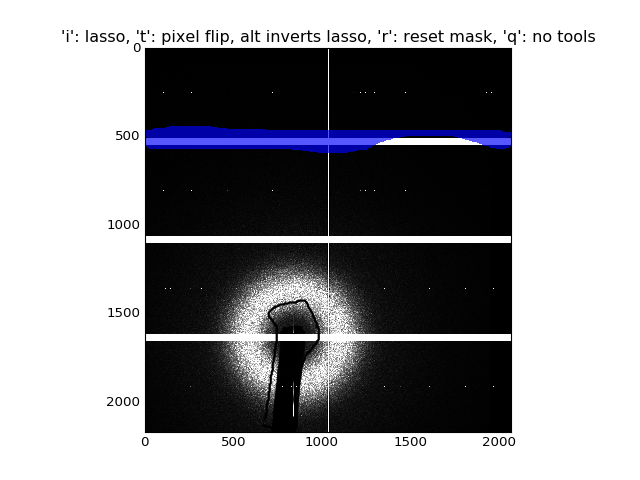

In [17]:
% matplotlib notebook

m = ManualMask(avg_img, vmin=0, vmax=1e0)

<IPython.core.display.Javascript object>


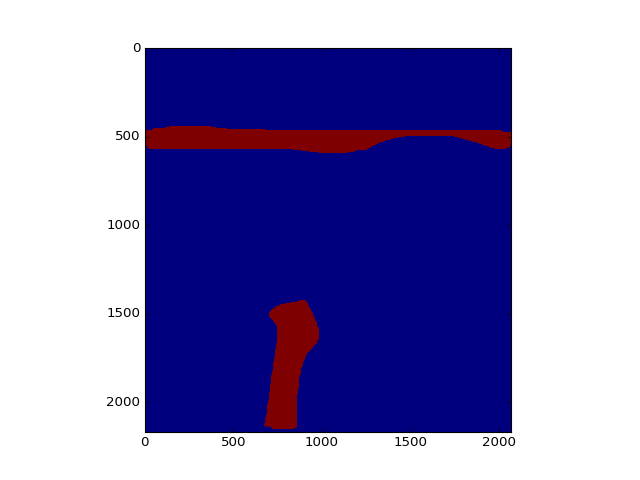

In [18]:
new_mask = m.mask

plt.imshow(new_mask)
plt.show()

## Input the mask file

In [19]:
cd Analysis_Pipelines/

/home/sameera/Analysis_Pipelines


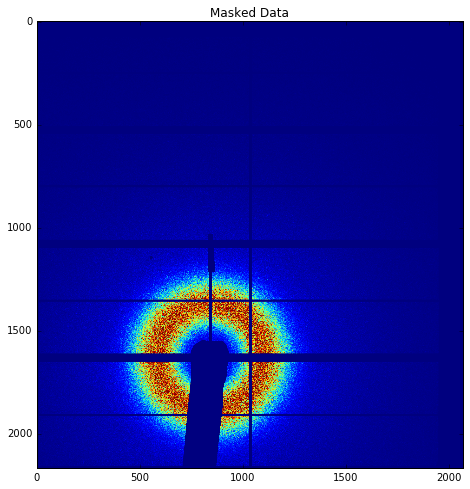

In [20]:
%matplotlib inline

mask = ~np.load("./mask2.npy")

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(avg_img*mask, vmin=0, vmax=1e0)
ax.set_title("Masked Data")
plt.show()

## Get the approximate center and see the statistic to make sure 

In [21]:
center = (1634.66, 838.6)  # center of the speckle pattern

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [22]:
bin_centers, ring_averages= roi.circular_average(avg_img*mask, center, threshold=0, nx=100,
                                         pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

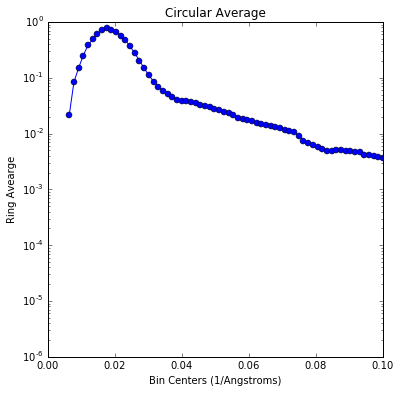

In [23]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
plt.show()

## Plot Kymograph (Waterfall plot) for a vertical and hortizontal cuts]


Note : Give coordinates of the upper-left corner and width and height of each
rectangle: e.g., [(x, y, w, h), (x, y, w, h)]


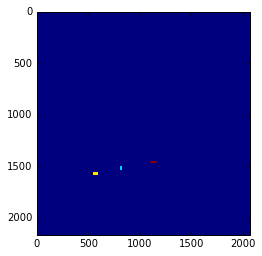

In [19]:
vert_rect = ((1500, 803, 40, 20), (1554, 546, 30, 40), (1454, 1098, 20, 60)) 

V_K_label_array = roi.rectangles(vert_rect, avg_img.shape)

plt.imshow(V_K_label_array)
plt.show()

In [54]:
veri_kymo = roi.kymograph(imgs, V_K_label_array*mask, num = 1)

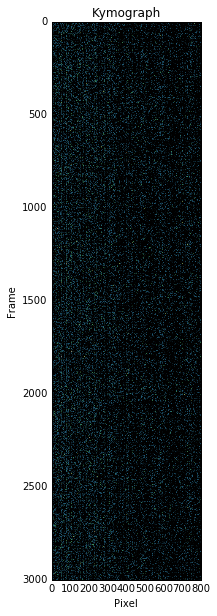

In [55]:
fig, ax = plt.subplots(figsize=(14,10))
ax.set_xlabel('Pixel')
ax.set_ylabel('Frame')
ax.set_title('Kymograph')
ax.imshow(veri_kymo, cmap='gist_earth')
plt.show()

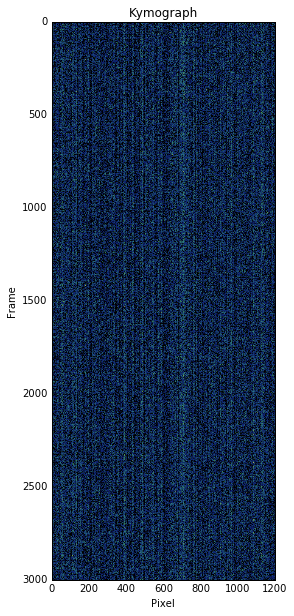

In [56]:
hori_kymo = roi.kymograph(imgs, V_K_label_array*mask, num=2)

fig, ax = plt.subplots(figsize=(14,10))
ax.set_xlabel('Pixel')
ax.set_ylabel('Frame')
ax.set_title('Kymograph')
ax.imshow(hori_kymo, cmap='gist_earth')
plt.show()

## Create label array (Q rings)

In [24]:
inner_radius = 100# radius of the first ring
width = 10        # width of each ring
spacing = 3      # no spacing between rings
num_rings = 15   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 100.,  110.],
       [ 113.,  123.],
       [ 126.,  136.],
       [ 139.,  149.],
       [ 152.,  162.],
       [ 165.,  175.],
       [ 178.,  188.],
       [ 191.,  201.],
       [ 204.,  214.],
       [ 217.,  227.],
       [ 230.,  240.],
       [ 243.,  253.],
       [ 256.,  266.],
       [ 269.,  279.],
       [ 282.,  292.]])

In [25]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_val

array([[ 0.00684144,  0.00752558],
       [ 0.00773083,  0.00841497],
       [ 0.00862021,  0.00930435],
       [ 0.0095096 ,  0.01019374],
       [ 0.01039898,  0.01108312],
       [ 0.01128836,  0.0119725 ],
       [ 0.01217774,  0.01286188],
       [ 0.01306712,  0.01375126],
       [ 0.0139565 ,  0.01464064],
       [ 0.01484588,  0.01553002],
       [ 0.01573526,  0.01641939],
       [ 0.01662463,  0.01730877],
       [ 0.01751401,  0.01819814],
       [ 0.01840338,  0.01908751],
       [ 0.01929275,  0.01997688]])

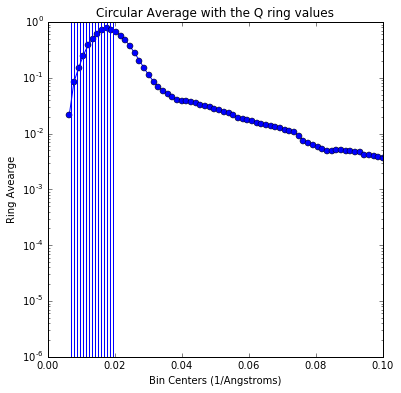

In [26]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average with the Q ring values")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
for i in range(num_rings):
    axes.axvline(q_ring_val[i, 0])
plt.show()

<IPython.core.display.Javascript object>


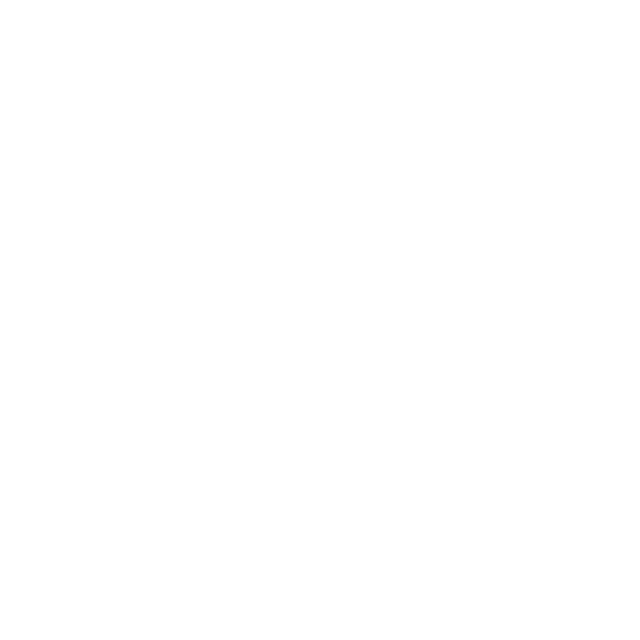

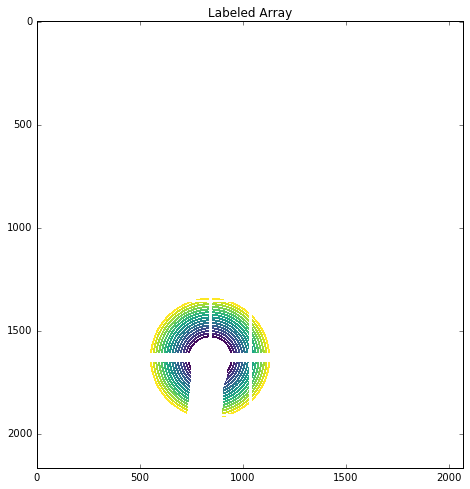

In [27]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask
% matplotlib notebook
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis')
plt.show()

##  Mean intensities for each ring

In [25]:
mask_data = imgs*mask
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

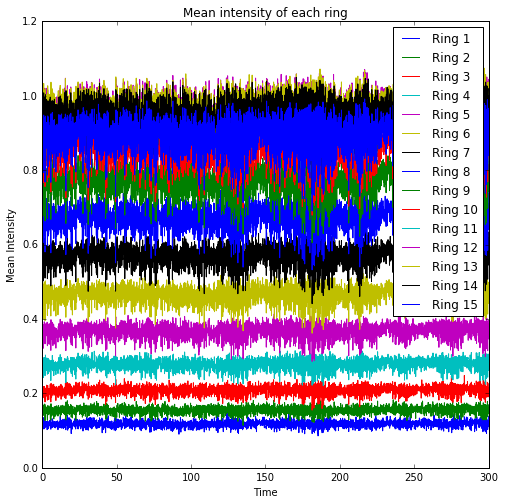

In [53]:
time = np.arange(len(imgs))*timeperframe  # get the time for each frame


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [28]:
num_lev = 9  
num_buf = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf, ring_mask,
                                             imgs*mask)

In [29]:
%matplotlib inline

### Plot the one time correlation functions

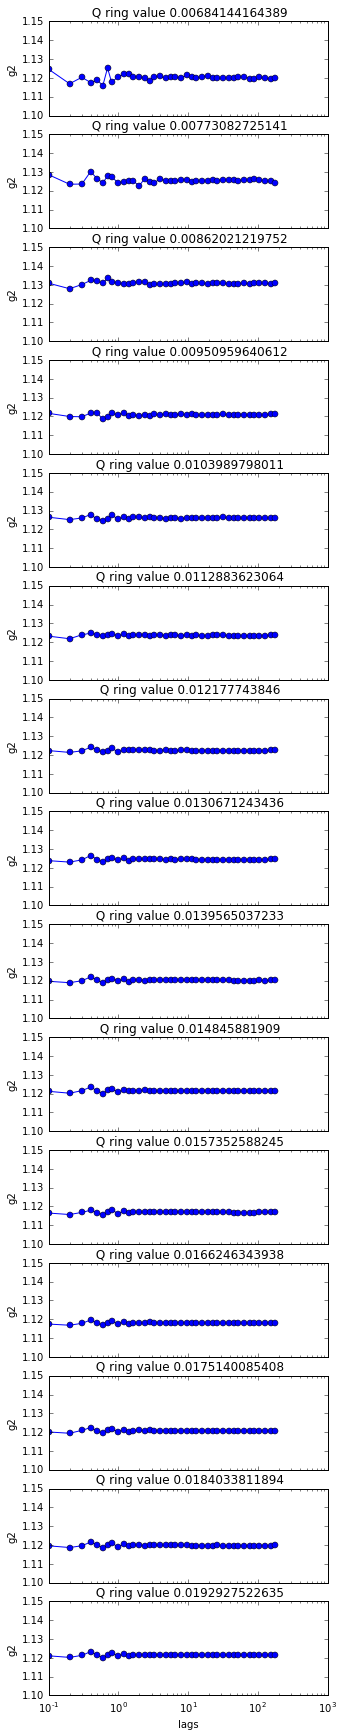

In [30]:
lags = lag_steps*timeperframe

fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5, 30))
axes[num_rings-1].set_xlabel("lags")
for i in range(num_rings):
    axes[i].set_ylabel("g2") 
    axes[i].set_title(" Q ring value " + str(q_ring_val[i, 0]))
    axes[i].semilogx(lags, g2[:, i], '-o', markersize=6)
    axes[i].set_ylim(bottom=1.10, top=1.15)
plt.show()